# Convolutional Neural Networks with Data Augmentation using Keras

---


## In this tutorial I will be using Keras with TensorFlow as backend to calssify digits from the MNIST Dataset

We will start by importing Keras.

In [1]:
import numpy
from keras import backend as K
from keras.datasets import mnist
from keras.utils import np_utils

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

We then import the layers of the convolutional neural network.The network consists of two main components :

1. Convolutional layers : the convolutional layer is responsible for the convolutional operation in which feature maps identifies features in the images.
and is usually followed by two types of layers which are :
>*   **Dropout** : Dropout is a regulization technique where you turn off part of the network's layers randomally to increase regulization and hense decrease overfitting. We use when the training set accuracy is muuch higher than the test set accuracy.
>*   **Max Pooling** : The maximum output in a rectangular neighbourhood. It is used to make the network more flexible to slight changes and decrease the network computationl expenses by extracting the group of pixels that are highly contributing to each feature in the feature maps in the layer.
2. Dense layers : The dense layer is a fully connected layer that comes after the convolutional layers and they give us the output vector of the Network.

As a convention in Convolutional Neural Network we decrease the dimensions of the layers as we go deeper and increase the number of feature maps to make it detect more features and decrease the number of computational cost.

![alt text](https://raw.githubusercontent.com/MoghazyCoder/Machine-Learning-Tutorials/master/assets/Untitled.png)

 

In [2]:
from keras.layers import Dense, Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

Sequential layers are stacked such that every layer passes its output to the next layer without you specifying extra information so we import Sequential from models

In [3]:
from keras.models import Sequential
import pandas as pd

We must specify which data format convention Keras will follow using the following line of code. Keras can accept the number of channels before other dimensions or after it but here we have to specify which convention we will use. We will use channels last which is Tensorflow's convention .

In [4]:
K.set_image_data_format('channels_last')
numpy.random.seed(0)

There are two csv files that contain the data for the training set and the test set when combined they form the mnist Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.  when we use the read_csv() function to read the dataset csv files.

In [5]:
X = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

y = X["label"]
X.drop(["label"], inplace = True, axis = 1)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2 , random_state=42)

We then reshape the samples according to TensorFlow convention which we chosed previously using "K.set_image_data_format('channels_last')" samples,rows,columns,channels as we are using channels_last if you are using channels_first you will need to change the order to samples,channels,rows,column and here we have only one channel because we are using the image in grayscale not RGB. We should also make the output in the form of one vs all (aka one hot encoding) which means that we will have 10 calsses from 0 to 9 one class for each number from 0 to 9



In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28 , 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28 , 1).astype('float32')

<h1>Data Exploration</h1>
Let's explore the data we have as this will give us a hint on the algorithm we will use if we have to choose. Exploring data is also very important because it will tell you which accuracy metric you are going to use, if the data is balanced which means all the classes have fair contribution in the dataset regarding its numbers then we can easily use accuracy, But if the data is skewed then we won't be able to use accurace as it's results will be misleading and we may use F-beta score instead.

the number of training examples = 33600
the number of classes = 10
Dimention of images = 28 x 28  
The number of occuranc of each class in the dataset = {0: 3316, 1: 3775, 2: 3331, 3: 3414, 4: 3233, 5: 3093, 6: 3352, 7: 3508, 8: 3228, 9: 3350}  



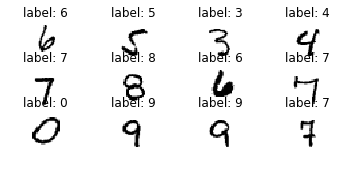

In [8]:
import matplotlib.pyplot as plt
print("the number of training examples = %i" % X_train.shape[0])
print("the number of classes = %i" % len(numpy.unique(y_train)))
print("Dimention of images = {:d} x {:d}  ".format(X_train[1].shape[0],X_train[1].shape[1])  )

#This line will allow us to know the number of occurrences of each specific class in the data
unique, count= numpy.unique(y_train, return_counts=True)
print("The number of occuranc of each class in the dataset = %s " % dict (zip(unique, count) ), "\n" )
 
images_and_labels = list(zip(X_train,  y_train))
for index, (image, label) in enumerate(images_and_labels[:12]):
    plt.subplot(5, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('label: %i' % label )

From the previous results we can see that the dataset consists of 60000 training example each is an image of dimention 28 * 28. We can see that the number of occurances of each class is almost balanced and based on that it is safe to use accuracy as our metric later.

<h1>  Model Design and Achitecture</h1>

Now lets implement the first layer of the convolutional network as shown in the schema below and i will use a simple archicture simillar to LeCun's network a .
![alt text](https://raw.githubusercontent.com/MoghazyCoder/Machine-Learning-Tutorials/master/assets/Layer.png)
For the sequential model you just stack the layers and only specify the image input dimensions in the first layer.
Our first layer will be a convolutional layer Conv2D() where we specify the number of feature maps , the input shape and the activation function which is here relu .The relu activation function is represented mathematically by max(0,X).
We then add the max pooling layer (which is the most common kind of pooling) with a kernel of dimensions 2 * 2 .


In [9]:
model = Sequential()

from keras.layers import Dropout

model.add(Conv2D(20, kernel_size=11, padding="valid", input_shape=(28, 28, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

Lets add the 2nd layer but this time we increase the feature maps .

In [10]:
model.add(Conv2D(40, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(50, kernel_size=3, padding="valid", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

Now we add a flatten layer that takes the output of the CNN and flattens it and passes it as an input to the Dense Layers which passes it to the output layer.
we have used number of classes = 10 because we have 10 numbers from 0 to 9 .
every dense layer contains 300 neurons except for the output layer.
We use Softmax with the output layer to output estimated probability vector for  multi-class classification .

In [11]:
from keras.layers.core import Activation

model.add(Flatten())
# model.add(Dense(units=1000, activation='relu'  ))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We have to compile the model and then try training it using the fit() function which fits the training data and labels , the number of epochs and the batch_size which is the number of photos per training cycle.
The last thing that we are going to do is to evaluate the model to ensure that it doesn't overfit the trainig data .Evaluating the model is done by using the weights that resulted from the training step and using it to estimate the value of the test data that the model haven't seen before to estimate how well the model will perform in the future on new data.

if you are using cross-validation split then the convention is to split the data by 60% training set , 20% validation set and 20% test set but in the era of big data this ratio may vary according to the amount of data you have.

We have used categorical_crossentropy as the cost function for that model but what does we mean by **cost function**

#### Cost function : It is a measure of the overall loss in our network after assigning values to the parameters during the forward phase so it indicates how well the parameters were chosen during the forward probagation phase.

#### Optimizer : It is the gradiant descent algorithm that is used. We use it to minimize the cost function to approach the minimum point. We are using adam optimizer which is one of the best gradient descent algorithms. You can refere to this paper to know how it works https://arxiv.org/abs/1412.6980v8

You can use other metrics to measure the performance other than accuracy as precision or recall or F1 score. the choice depends on the problem itself. Where high recall means low number of false negatives , High precision means low number of false positives and     F1 score is a trade off between them. You can refere to this article for more about precision and recall http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [12]:
y_train = np_utils.to_categorical(y_train).astype('int32')
y_test = np_utils.to_categorical(y_test)

I will use ImageDataGenerator from keras to augment the images. Augmenting the images makes the model more robust and more generalizable when using newly unseen data like the data in the test set of the competition. There are many ways to augment the images like centering the images, normalization, rotation, shifting, and flipping and i will use some of them [here](http://) .

In [13]:
from tensorflow import keras

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-1,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=100,
        verbose=1)
]

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=5,
    fill_mode='nearest',
    validation_split = 0.2
    )

datagen.fit(X_train)

train_generator = datagen.flow(X_train, y_train, batch_size=60, subset='training')

validation_generator = datagen.flow(X_train, y_train, batch_size=60, subset='validation')


# # fits the model on batches with real-time data augmentation:
history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks = callbacks,
                    use_multiprocessing=True,
                    steps_per_epoch = len(train_generator) / 60,
                    validation_steps = len(validation_generator) / 60,
                    epochs = 400,
                    workers=20)

Epoch 1/400

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



8/7 [================================] - 9s 1s/step - loss: 2.0641 - acc: 0.2917 - val_loss: 2.3437 - val_acc: 0.1667
Epoch 2/400
8/7 [================================] - 0s 17ms/step - loss: 1.5584 - acc: 0.5583 - val_loss: 2.0640 - val_acc: 0.3833
Epoch 3/400
8/7 [================================] - 0s 21ms/step - loss: 1.3294 - acc: 0.6250 - val_loss: 1.5232 - val_acc: 0.4500
Epoch 4/400
8/7 [================================] - 0s 23ms/step - loss: 0.9971 - acc: 0.7146 - val_loss: 1.1259 - val_acc: 0.5667
Epoch 5/400
8/7 [================================] - 0s 20ms/step - loss: 0.5425 - acc: 0.8583 - val_loss: 0.9042 - val_acc: 0.7667
Epoch 6/400
8/7 [================================] - 0s 21ms/step - loss: 0.6404 - acc: 0.8083 - val_loss: 0.6649 - val_acc: 0.8000
Epoch 7/400
8/7 [================================] - 0s 22ms/step - loss: 0.2708 - acc: 0.9396 - val_loss: 0.6652 - val_acc: 0.7667
Epoch 8/400
8/7 [================================] - 0s 19ms/step - loss: 0.3827 - acc: 0

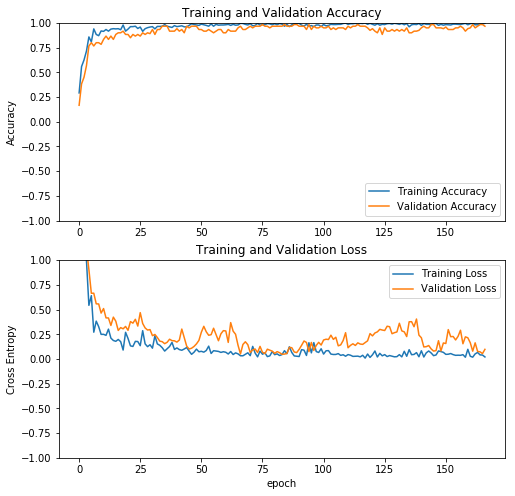

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
# model.fit(X_train, y_train, epochs= 32 , batch_size=200, validation_split = 0.2)
scores = model.evaluate(X_test, y_test, verbose = 10 )
print ( scores )


[0.6623788328397234, 0.9575]


In [17]:
test_set = (test.values).reshape(-1, 28, 28 , 1).astype('float32')

res = model.predict(test_set)
res = numpy.argmax(res,axis = 1)
res = pd.Series(res, name="Label")
submission = pd.concat([pd.Series(range(1 ,28001) ,name = "ImageId"),   res],axis = 1)
submission.to_csv("cnn_mnist_datagen.csv",index=False)
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,9
6,7,0
7,8,3
8,9,0
9,10,3


Note that these results can be further optimized and regulized but i will leave that for you. Knowing how to optimize the results is very important and can be done using error analysis techniques.

### This tutorial is written by AbdElRhman ElMoghazy.

### Refrences ,Textbooks and Tutorials :
Hands on machine learning with scikit-learn and TensorFlow by Aurélien Géron

Pyhron machine learning 2nd edition by Sebastian Raschka ,Vahid Mirjalili

http://www.deeplearningbook.org/

https://keras.io/

https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..%2Findex#0